## Load dependencies

In [1]:
project_name = 'kornet'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from glob import glob as glob
import pdb
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = f'{git_dir}/data'
results_dir = f'{git_dir}/results'
fig_dir = f'{git_dir}/figures'


sub_info = pd.read_csv(f'{data_dir}/sub_info.csv' )
#remove subjects with NaNs in code field
#sub_info = sub_info[~sub_info['code'].isna()]
#remove subjects with 1 in exclude field
sub_info = sub_info[sub_info['exclude'] != 1]


#child vars
human_vars = ['3yrold_fast','3yrold_slow','4yrold_fast','4yrold_slow','5yrold_fast','5yrold_slow', 'adult_fast','adult_slow']
human_labels = ['3yrold-fast','3yrold-slow','4yrold-fast','4yrold-slow','5yrold-fast','5yrold-slow', 'Adult-fast','Adult-slow']

#model colors actually includes human data too
#
model_colors = [sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:], #this one is child and adult colors 
                sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + #vonenet to cvcl models
                    sns.light_palette("orange", 5)[-2:] + sns.light_palette("violet", 5)[-2:], #convnext to dino and clip models
                sns.light_palette("gold", 3)[-2:] + sns.light_palette("purple", 5)[-3:5]] #controlled resnet models

model_colors = [sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:],
                sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + sns.light_palette("orange", 5)[-2:] + sns.light_palette("violet", 5)[-2:],
                sns.light_palette("gold", 3)[-3:] + sns.light_palette("purple", 5)[-2:5]]  

exp1_model_n = 10
exp2_model_n = 6

#create a list with ones corresponding to exp1 models and 2s corresponding to exp2 models
fig_order = [1]*exp1_model_n + [2]*exp2_model_n

conds = ['complete', 'perturbed','deleted']
model_conds = ['Outline','Pert','IC']
durations = [.3,.25, .2,.15,.1]
duration_labels = [300, 250, 200, 150, 100]
speed = ['intro','slow','slow','fast','fast']

age_groups = ['3yrold','4yrold','5yrold','adult']



#### Compute CIs

In [4]:
'''Calculate boostrap CIs'''
#timeit
def compute_cis(df, iter = 10000):

    
    #initialize empty df
    boot_acc = []
    for i in range(0,iter):
        #sample with replacement
        df_boot = df.sample(n = len(df), replace = True)

        #calculate mean of acc
        acc = df_boot['acc'].mean()

        boot_acc.append(acc)

    #calculate 95% CI
    ci = np.percentile(boot_acc, [2.5, 97.5])

    return ci[0], ci[1]


     

## Model analyses - First Exp

In [4]:
#models for model figs
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 
              'SayCam', 'cvcl',
                'convnext', 'vit', 'vit_dinov2','clip_vit',
                'resnet50', 'resnet50_imagenet-sketch','resnet50_21k', 
                'resnet50_dino','clip_resnet_15m', 'clip_resnet']

model_names = ['VoneNet_FF-EcoSet', 'VoneNet_FF-EcoSet-Style', 'VoneNet_R-EcoSet', 'VoneNet_R-EcoSet-Style', 
               'ResNext50_SAY', 'CVCL',
               'ConvNext-ImageNet1k', 'ViT-ImageNet1k','ViT-DINOv2', 'ViT-CLIP',
               'ResNet50-ImageNet1k','ResNet50-ImageNet-Sketch', 'ResNet50-ImageNet21k',
               'ResNet50-DINO','ResNet50-YFCC15m', 'ResNet50-CLIP']



''' model params'''
model_colors = [sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:],
                sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + sns.light_palette("orange", 5)[-2:] + sns.light_palette("violet", 5)[-2:],
                sns.light_palette("gold", 4)[-3:] + sns.light_palette("purple", 5)[-3:]]  


exp1_model_n = 10
exp2_model_n = 6

#create a list with ones corresponding to exp1 models and 2s corresponding to exp2 models
fig_order = [1]*exp1_model_n + [2]*exp2_model_n






model_conds = ['Outline','Pert','IC']
cond_names = ['complete','perturbed','deleted']


suf ='_all'


#classifiers used
classifiers = ['SVM', 'Ridge', 'NB', 'KNN', 'logistic', 'NC']

#number of training images evaluated
train_ns = [5, 10, 25, 50, 100, 150, 200, 250, 300]


#load data
sub_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long_imputed_at_chance.csv')

#load adult data
sub_summary_adult = pd.read_csv(f'{results_dir}/group_data/sub_summary_adult.csv')
#combine
sub_summary = pd.concat([sub_summary, sub_summary_adult], axis = 0)


#remove .35 duration
sub_summary = sub_summary[sub_summary['duration'] < .3]




### Best performing models

In [32]:
'''
Determine best performing version of each model and then compare across models and children
'''



for cond in model_conds:
    print(cond)
    full_summary = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc', 'ci_low', 'ci_high','fig_number'])    
    
    '''First add kids and adult data'''
    for age in age_groups:
        for speed in ['fast', 'slow']:
            #extract sub data for age, cond, and speed
            temp_sub_summary = sub_summary[(sub_summary['age_group']==age) & (sub_summary['cond']==conds[model_conds.index(cond)]) & (sub_summary['speed']==speed)]
            

            #calculate mean acc
            acc = temp_sub_summary.loc[temp_sub_summary['speed']==speed,'acc'].mean()


            ci_low, ci_high = compute_cis(temp_sub_summary)


            #compile data into list
            temp_df = [f'{age}_{speed}', '','',conds[model_conds.index(cond)], acc, ci_low, ci_high, 0]
            temp_summary = pd.DataFrame([temp_df], columns = full_summary.columns)

            #add fig_number to temp_summary
            #temp_summary['fig_number'] = 0
            #append ot full_summary
            full_summary = pd.concat([full_summary, temp_summary], axis = 0)


    '''Now add best model for each architecture'''
    for model in model_arch:
        model_df = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc','ci_low','ci_high'])
        for classifier in classifiers:
        

            for train_n in train_ns:
                
                    model_file = f'{results_dir}/models/{model}_{classifier}_train{train_n}_test{cond}.csv'
                    if os.path.exists(model_file):
                        temp_df = pd.read_csv(model_file)

                        #groupby 
                        temp_df_mean = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].mean().reset_index()

        

                        
                        
                        
                        model_df = pd.concat([model_df, temp_df_mean], axis = 0)
                    else:
                        print(f'no {model}_{classifier}_train{train_n}_test{cond}.csv')

        #find best variation of current model
        best_model = model_df[model_df['acc'] == model_df['acc'].max()]

        #if there are more than one best model, take the one with the fewest training images
        if len(best_model) > 1:
            best_model = best_model[best_model['train_ims'] == best_model['train_ims'].min()]

        #reload best model file
        model_file = f'{results_dir}/models/{best_model["model"].values[0]}_{best_model["classifier"].values[0]}_train{best_model["train_ims"].values[0]}_test{cond}.csv'
        best_model_data = pd.read_csv(model_file)

        #compute CIs
        ci_low, ci_high = compute_cis(best_model_data)

        #add CI to best_model
        best_model['ci_low'] = ci_low
        best_model['ci_high'] = ci_high

        
        #add fig_number to best_model
        best_model['fig_number'] = fig_order[model_arch.index(model)]
        #add best_model to full_summary
        full_summary = pd.concat([full_summary, best_model], axis = 0)


    #rename model names
    full_summary['model'] = full_summary['model'].replace(dict(zip(model_arch, model_names)))

    #rename human vars
    full_summary['model'] = full_summary['model'].replace(dict(zip(human_vars, human_labels)))
    

    #save
    full_summary.to_csv(f'{results_dir}/{cond_names[model_conds.index(cond)]}_model_comparison{suf}.csv', index = False)
                    




Outline


Pert
IC


#### Plot model bars

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


complete


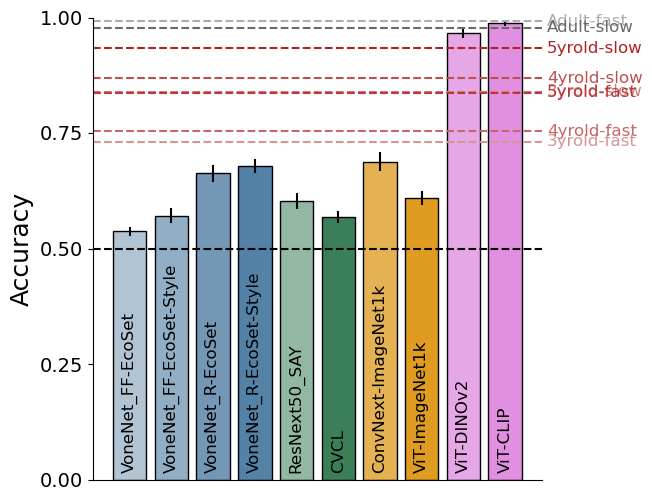

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


perturbed


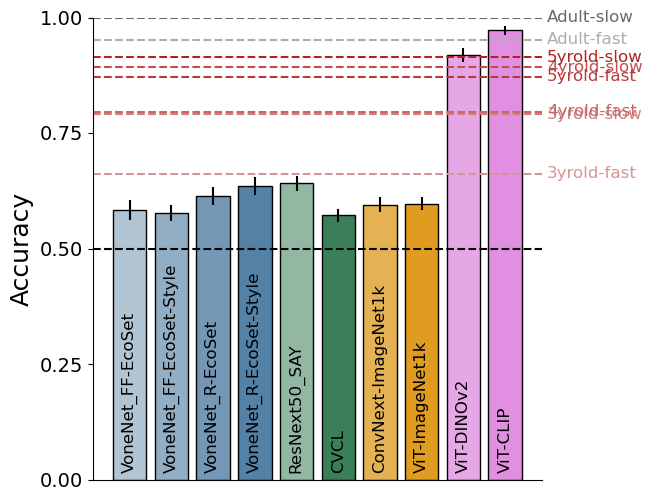

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


deleted


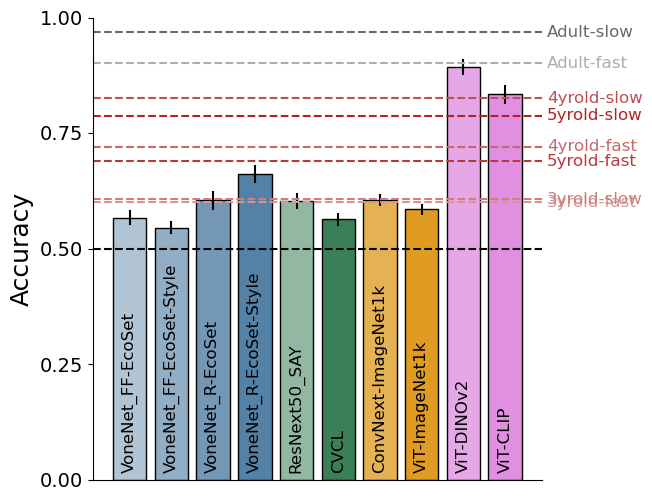

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


complete


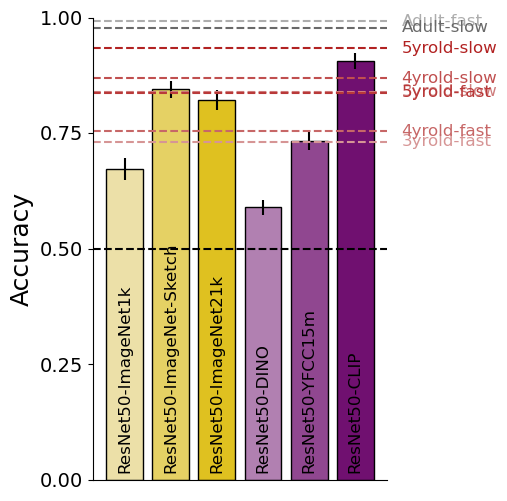

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


perturbed


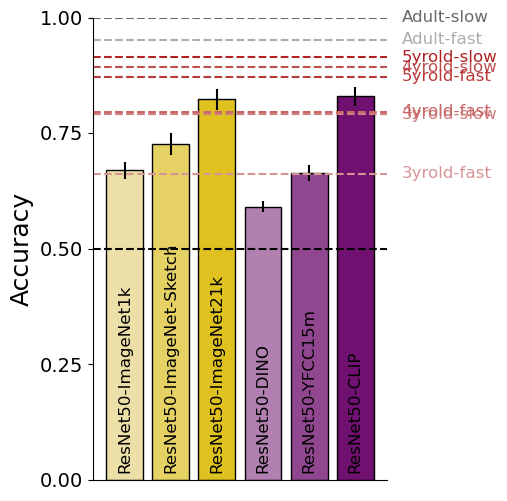

deleted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


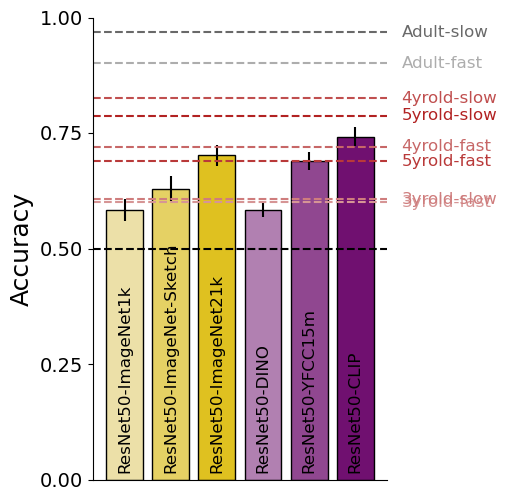

In [10]:
fig_sizes = [6.3, 2.8]


human_colors = sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:]

model_colors = [sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + sns.light_palette("orange", 5)[-2:] + sns.light_palette("violet", 5)[-2:],
                sns.light_palette("gold", 4)[-3:] + sns.light_palette("purple", 5)[-3:]]  

for panel in [0,1]: #panel corresopnds to models in first and second experiments/analyses
    

    for cond in cond_names:

        if panel == 0:
            fig, ax = plt.subplots(figsize=(5.8,6))
        else:
            fig, ax = plt.subplots(figsize=(3.8,6))
        
        print(cond)

        all_organisms = pd.read_csv(f'{results_dir}/{cond}_model_comparison{suf}.csv')

        #extract human data
        human_data = all_organisms[all_organisms['model'].isin(human_labels)]

        #extract model data
        model_data = all_organisms[~all_organisms['model'].isin(human_labels)]
  
        
        full_summary = all_organisms[all_organisms['fig_number'] == (panel+1)]

        
        #Make bar plot with each model as a different color, and CIs for error bars
        sns.barplot(data = full_summary, x = 'model', y = 'acc', hue = 'model', dodge=False, palette=model_colors[panel], edgecolor = 'k')

        #add error bars

        plt.errorbar(x = full_summary['model'], y = full_summary['acc'], yerr = [full_summary['acc'] - full_summary['ci_low'], full_summary['ci_high']-full_summary['acc']] , fmt = 'none', color = 'black', capsize = 0)

        #set y limits
        plt.ylim(0,1)
    
        #set ylabel
        plt.ylabel('Accuracy', fontsize = 18)
        
        #increase font size of y axis labels
        #plt.set_yticklabels(fontsize = 20)

        #set y-axis increments to .25
        plt.yticks(np.arange(0, 1.25, .25))
        plt.tick_params(axis='y', labelsize=14)
        

            
        #remove tick labels
        
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        

        #remove x axis label
        #plt.xlabel('')
            #remove x ticks and labels
        plt.xticks([])
        #plt.set_xticklabels([])
        plt.xlabel('')


        #add labels to the inside of the bars
        for p, model_name in zip(ax.patches, full_summary['model']):
            ax.annotate(f'{model_name}', (p.get_x() + p.get_width() / 2., 0 ),
                    ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), rotation = 90,
                    textcoords='offset points')

        '''
        #move labels inside bars
        for p, model_name in zip(plt.patches, full_summary['model']):
            plt.annotate(f'{model_name}', (p.get_x() + p.get_width() / 2., 0 ),
                        ha='center', va='bottom', fontsize=15, color='black', xytext=(0, 5), rotation = 90,
                        textcoords='offset points')
        '''
    


        #remove legend
        plt.legend().remove()

        #remove top and right spines
        sns.despine()
        

        

        #loop through human data and horizontal line
        for i, human_acc in enumerate(human_data['acc']):
            plt.axhline(y=human_acc, color=human_colors[i], linestyle='--')
            
            plt.text(len(full_summary), human_acc, f'{human_labels[i]}', fontsize = 12, color = human_colors[i], va = 'center')

        plt.axhline(y=.5, color='black', linestyle='--')
        #plt.subplots_adjust(wspace=.1, hspace=0)
        #save
        plt.savefig(f'{fig_dir}/{cond}_model_comparison{suf}_exp{panel+1}.png', dpi = 300, bbox_inches = 'tight')
        
        plt.pause(.001)



### Performance by layer

Outline


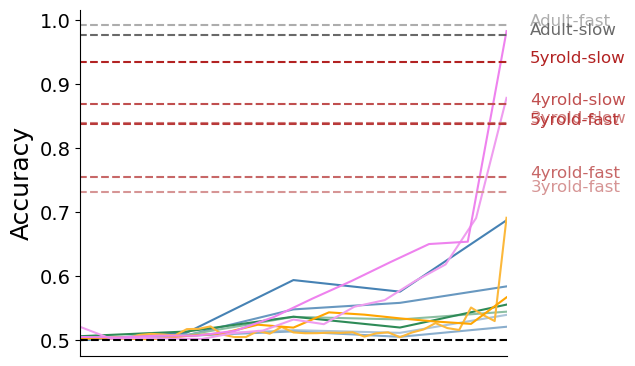

Pert


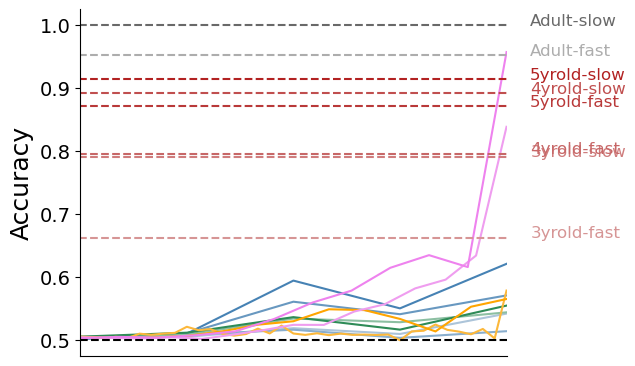

IC


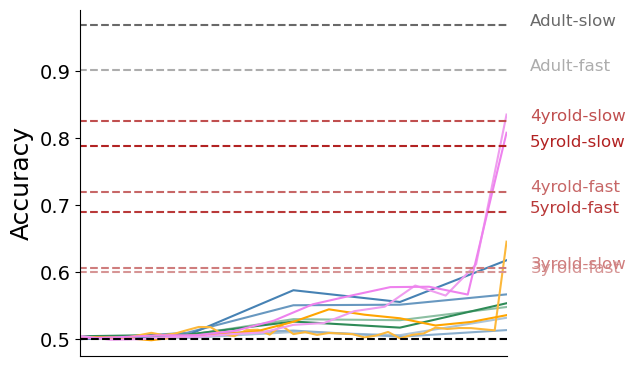

In [25]:
classifier = 'KNN'
train_n = 150
model_conds = ['Outline','Pert','IC']

model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 
              'SayCam', 'cvcl',
                'convnext', 'vit','vit_dinov2', 'clip_vit']
                #'resnet50', 'resnet50_21k','clip_resnet_15m', 'clip_resnet']
all_colors = model_colors[0] + model_colors[1]

#model_arch = ['vit_dinov2', 'resnet50_dino','resnet50_imagenet-sketch']
#model_arch = ['vonenet_ff_ecoset_imagenet_sketch','vonenet_r_ecoset_imagenet_sketch', 'vonenet_ff_ecoset', 'vonenet_r_ecoset']

for cond in model_conds:
    print(cond)
    model_df = pd.DataFrame(columns = ['model','classifier','train_ims','condition','layer','layer_num','acc'])
    layer_n = []
    for model in model_arch:
        
        model_file = f'{results_dir}/models/{model}_{classifier}_train{train_n}_test{cond}_layerwise.csv'
        if os.path.exists(model_file):
            temp_df = pd.read_csv(model_file)
            #add layer number based on unique layers
            temp_df['layer_num'] = temp_df.groupby(['model','classifier','train_ims','condition'])['layer'].transform(lambda x: pd.factorize(x)[0])+1

            #groupby layer
            temp_df_mean = temp_df.groupby(['model','classifier','train_ims','condition','layer','layer_num'])['acc'].mean().reset_index()

            model_df = pd.concat([model_df, temp_df_mean], axis = 0)

            #count number of layers
            layer_n.append(len(temp_df_mean['layer'].unique()))



    #sort model_df by model then layer_num
    model_df = model_df.sort_values(['model','layer_num'])

    #find max layer number
    max_layer = np.max(layer_n)

    #loop back through models and add stretched layer number
    for model in model_arch:
        model_layers = len(model_df[model_df['model'] == model]['layer_num'].values)

        #create linspace from 1 to max_layer by number of layers
        stretched_layers = np.linspace(1,max_layer, model_layers)

        #replace layer_num with stretched_layers
        model_df.loc[model_df['model'] == model,'layer_num'] = stretched_layers


        

    human_cond = conds[model_conds.index(cond)]
    all_organisms = pd.read_csv(f'{results_dir}/{human_cond}_model_comparison{suf}.csv')
    #extract human data from all_organisms
    human_data = all_organisms[all_organisms['model'].isin(human_labels)]



    #make model into a categorical variable
    model_df['model'] = pd.Categorical(model_df['model'], categories = model_arch, ordered = True)

    #plot model_df as a function of layer_num
    fig, ax = plt.subplots(1,1, figsize=(5.5,4.5))

    sns.lineplot(data = model_df, x = 'layer_num', y = 'acc', hue = 'model',palette=all_colors)

    #add label to the end of each line for each model
    #for i in range(len(model_arch)):
    #    ax.text(max_layer+1, model_df[model_df['model'] == model_arch[i]]['acc'].values[-1], model_arch[i], color = model_colors[i], fontsize = 14)

    #loop through human data and add to plot as horizontal lines using human_colors
    for i in range(len(human_data)):
        ax.hlines(y=human_data['acc'].values[i], xmin =0, xmax =max_layer,color = human_colors[i], linestyle = '--')


    
    #put legend outside of plot
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

    #remove legend
    ax.legend().remove()

    #add labels at the end of each line
    for i in range(len(human_data)):
        ax.text(max_layer+2, human_data['acc'].values[i], human_data['model'].values[i], color = human_colors[i], fontsize = 12)

    #add dotted black line at .5
    ax.axhline(y=.5, color='black', linestyle='--')


    #set xlim at 1
    ax.set_xlim([1,max_layer])

    #remove x labels and title
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_xlabel('')
    plt.tick_params(axis='y', labelsize=14)

    #remove right and top borders
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #set y label to Accuracy
    ax.set_ylabel('Accuracy', fontsize = 18)

    #save
    cond_name = cond_names[model_conds.index(cond)]
    plt.savefig(f'{fig_dir}/{cond_name}_layerwise{suf}.png', dpi = 300, bbox_inches = 'tight')
    plt.pause(.001)

        

## Acc x Experience

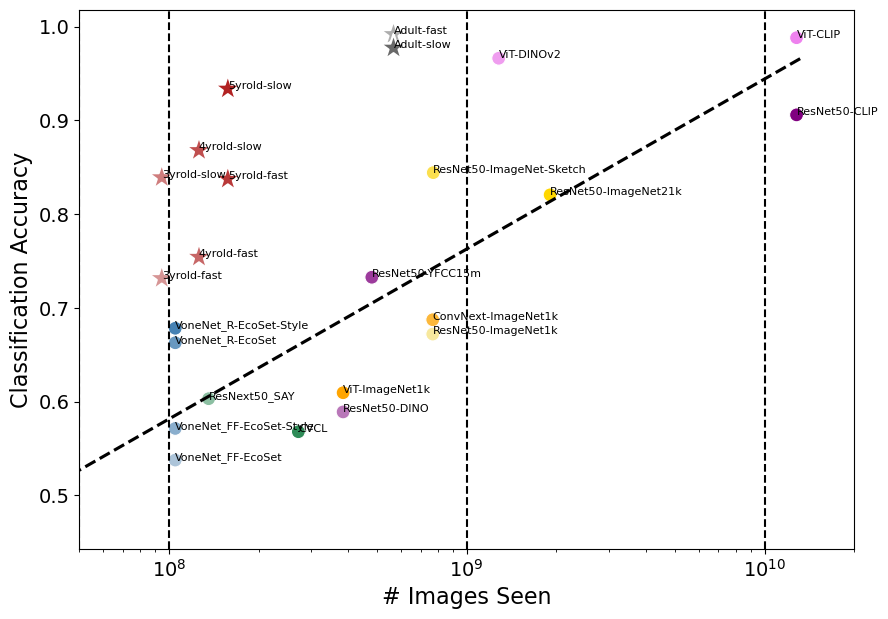

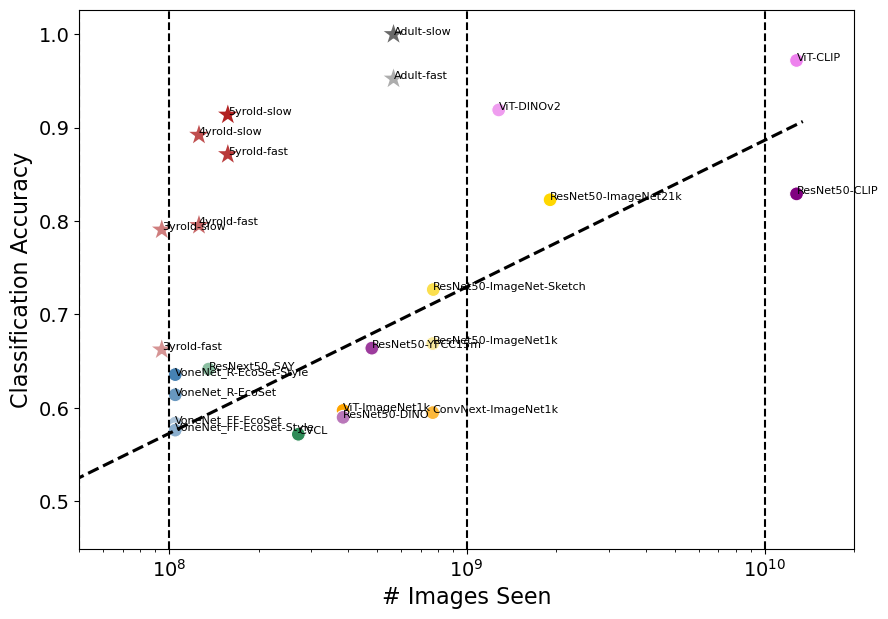

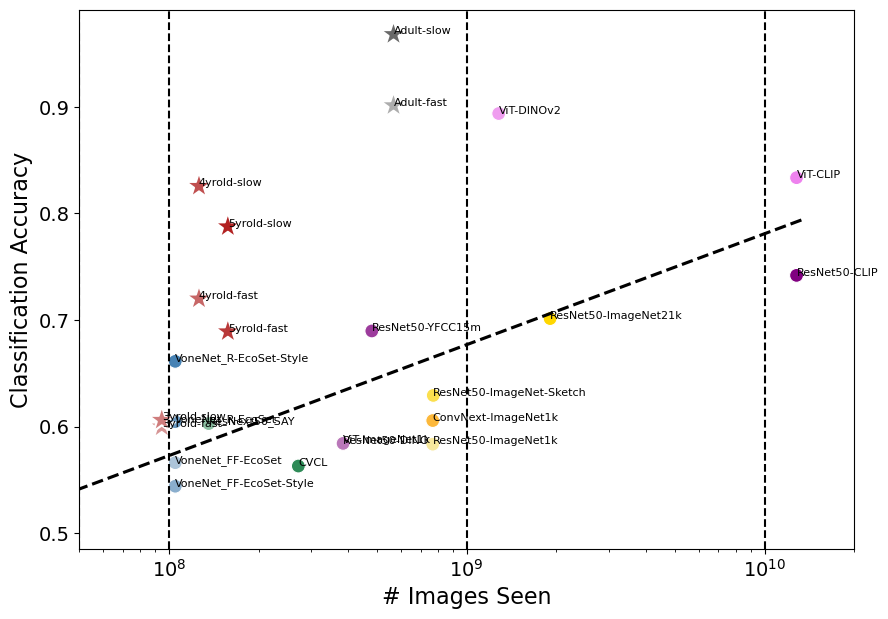

In [13]:
#load train size xlsx
train_size = pd.read_excel(open(f'{git_dir}/modelling/train_sizes.xlsx', 'rb'), sheet_name='Sheet1')
human_colors = sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:]

model_colors = [sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + sns.light_palette("orange", 5)[-2:] + sns.light_palette("violet", 5)[-2:],
                sns.light_palette("gold", 4)[-3:] + sns.light_palette("purple", 5)[-3:]]  


all_model_colors = model_colors[0] + model_colors[1]

model_conds = ['Outline','Pert','IC']
cond_names = ['complete','perturbed','deleted']


for cond in cond_names:
    all_organisms = pd.read_csv(f'{results_dir}/{cond}_model_comparison_all.csv')

    #add column for train size
    #all_organisms['train_ims'] = 0
    

    #all_organisms['total_training'] = 0
    

    #merge trainings sizes with all_organisms by model column
    all_organisms = pd.merge(all_organisms, train_size, on = 'model', how = 'left')

    #log transform training size
    #all_organisms['dataset_size'] = np.log(all_organisms['dataset_size'])
    #all_organisms['total_training'] = np.log(all_organisms['total_training'])

    #extract model data
    model_data = all_organisms[all_organisms['organism']=='model']
    
    human_data = all_organisms[all_organisms['organism']=='human']




    #log transform training size
    #all_organisms['train_ims'] = np.log(all_organisms['train_ims'])
    #all_organisms['total_training'] = np.log(all_organisms['total_training'])

    

    #create scatter plot of accuracy vs total training using square markers
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.scatterplot(data = model_data, x = 'total_training', y = 'acc', hue = 'model', palette = all_model_colors, s = 100)
    #sns.scatterplot(data = model_data, x = 'dataset_size', y = 'acc', hue = 'model', palette = all_model_colors, s = 100)
    sns.scatterplot(data = human_data, x = 'total_training', y = 'acc', hue = 'model', palette = human_colors, s = 400, marker='*')



    #add trendline for model data
    model_data = all_organisms[all_organisms['organism']=='model']
    sns.regplot(data = model_data, x = 'total_training', y = 'acc', scatter = False, color = 'black', ci = None,logx=True, truncate=False, line_kws={'linestyle':'--'})
    #sns.regplot(data = model_data, x = 'dataset_size', y = 'acc', scatter = False, color = 'black', ci = None,logx=True, truncate=False)
    
    
    #xlim = 50 million to 20 billion
    plt.xlim(50000000, 20000000000)

    #xticks = 50 million to 20 billion
    plt.xticks([50000000, 100000000, 1000000000, 10000000000], ['50M', '100M', '1B', '10B'])

    
    
    


    #move legend outside of plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

    #add Y axis
    plt.ylabel('Classification Accuracy', fontsize = 16)
    plt.xlabel('# Images Seen', fontsize = 16)

    #Mmake x axis log scale
    plt.xscale('log')

    #increase font size of x and y labels
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    

    #remove legend
    plt.legend().remove()

    #save
    plt.savefig(f'{fig_dir}/{cond}_acc_by_experience_nolabel.png', dpi = 300, bbox_inches = 'tight')

    #add labels to each point 
    for i in range(len(model_data)):
        ax.text(model_data['total_training'].values[i]+.1, model_data['acc'].values[i], model_data['model'].values[i], fontsize = 8)

    #add labels to human data
    for i in range(len(human_data)):
        ax.text(human_data['total_training'].values[i]+.1, human_data['acc'].values[i], human_data['model'].values[i], fontsize = 8)

    #add line at 50 million images
    plt.axvline(x=50000000, color='black', linestyle='--')
    #add line at 100 million images
    plt.axvline(x=100000000, color='black', linestyle='--')

    #add line at 1 billion images
    plt.axvline(x=1000000000, color='black', linestyle='--')

    #add line at 10 billion images
    plt.axvline(x=10000000000, color='black', linestyle='--')


    #save
    plt.savefig(f'{fig_dir}/{cond}_acc_by_experience.png', dpi = 300, bbox_inches = 'tight')
    plt.pause(.001)



## RSA analyses

In [30]:
#load rdm summary
rdm_summary = pd.read_csv(f'{results_dir}/rdm_summary.csv')

model_conds = ['Outline','Pert','IC']
conds = ['complete', 'perturbed','deleted']
classifier = 'KNN'


for cond in conds:
    model_cond = model_conds[conds.index(cond)]
    model_data_top = pd.read_csv(f'{results_dir}/{cond}_model_comparison_all.csv')
    cond_summary = pd.DataFrame(columns=['model','layer','corr', 'acc'])
    #extract data for current condition
    cond_rdm = rdm_summary[f'{cond}_overall']

    #loop through models and layers
    for model in model_arch:
        #extract unique layers
        model_data = pd.read_csv(f'{results_dir}/models/{model}_{classifier}_train150_test{model_cond}_layerwise.csv')
        top_layer_acc= model_data_top[model_data_top['model'] == model_names[model_arch.index(model)]]['acc'].values[0]

        #grab layer in last row
        top_layer = model_data['layer'].values[-1]

        #extract unique layers
        layers = model_data['layer'].unique()
        for layer in layers:
            
            #extract rdm for current model and layer
            model_rdm = rdm_summary[f'{model}_{cond}_{layer}']
            
            #add both rdms to new dataframe
            combined_rdm = pd.DataFrame([model_rdm, cond_rdm]).T

            #remove rows with missing data
            combined_rdm = combined_rdm.dropna()

            #calculate correlation with human data
            corr = combined_rdm.corr().iloc[0,1]
            
            acc = model_data[model_data['layer'] == layer]['acc'].mean()
            #if top layer, add top layer acc to acc
            if layer == top_layer:
                acc = top_layer_acc
                layer = 'top'

            #add to cond_summary
            temp_df = [model, layer, corr, acc]
            temp_summary = pd.DataFrame([temp_df], columns = cond_summary.columns)
            
            cond_summary = pd.concat([cond_summary, temp_summary], axis = 0)

    #save
    cond_summary.to_csv(f'{results_dir}/{cond}_rsa_summary.csv', index = False)



    #scatter plot of correlation with human data vs accuracy
    print(cond)


complete
perturbed
deleted


complete


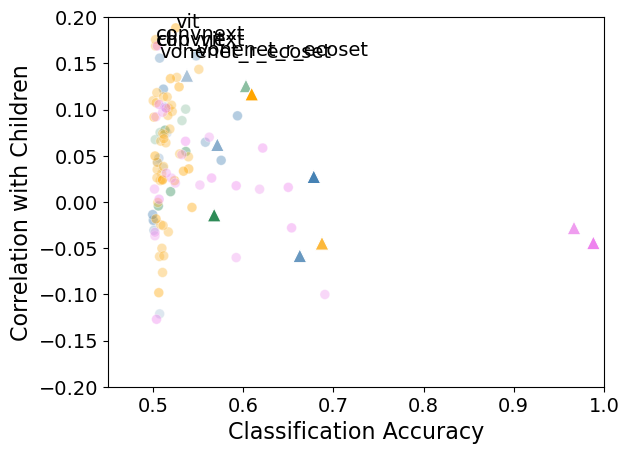

perturbed


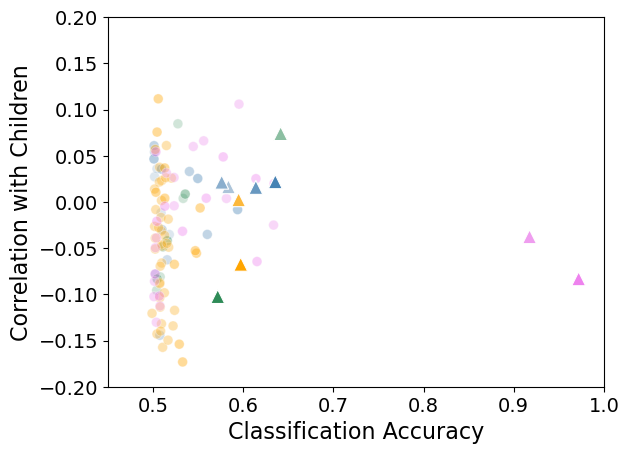

deleted


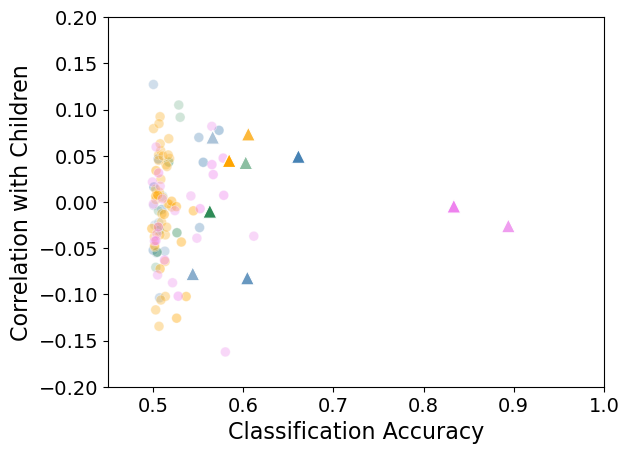

In [12]:
all_model_colors = model_colors[0] + model_colors[1]
for cond in conds:
    print(cond)
    #load rsa
    cond_summary = pd.read_csv(f'{results_dir}/{cond}_rsa_summary.csv')

    #extract top layer data
    top_layer_data = cond_summary[cond_summary['layer'] == 'top']

    #extract non-top layer data
    cond_summary = cond_summary[cond_summary['layer'] != 'top']

    #combine all model colors
    
    #fig, ax = plt.subplots(1,1, figsize=(10,7))


    sns.scatterplot(data = cond_summary, x = 'acc', y = 'corr', hue = 'model', palette = all_model_colors, alpha = .4, s = 50)
    sns.scatterplot(data = top_layer_data, x = 'acc', y = 'corr', hue = 'model', palette = all_model_colors, s = 100, marker='^')
    
    #add top layer data
    #for i in range(len(top_layer_data)):
    #    plt.scatter(top_layer_data['acc'].values[i], top_layer_data['corr'].values[i], color = all_model_colors[i], s = 100)
        
    
    #add labels to points where acc > .7 and corr > .15
    for i in range(len(cond_summary)):
        if cond_summary['acc'].values[i] > .7 or cond_summary['corr'].values[i] > .15:
            plt.text(cond_summary['acc'].values[i], cond_summary['corr'].values[i], cond_summary['model'].values[i], fontsize = 14)

    '''
    #add labels to top layer data
    for i in range(len(top_layer_data)):
        plt.text(top_layer_data['acc'].values[i], top_layer_data['corr'].values[i], top_layer_data['model'].values[i], fontsize = 14)
    #move legend outside of plot
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
    '''

    #add X and Y labels
    plt.xlabel('Classification Accuracy', fontsize = 16)
    plt.ylabel('Correlation with Children', fontsize = 16)

    #increase font size of x and y labels
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    #set lims
    plt.ylim([-.2,.2])
    plt.xlim([.45,1])

    #remove legend
    plt.legend().remove()

    plt.pause(.001)


## Fine-tuned models

In [5]:
model_arch = ['vonenet_ff_ecoset_imagenet_sketch','vonenet_r_ecoset_imagenet_sketch', 'vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset',
              'vonenet_r_stylized-ecoset_imagenet_sketch', 'resnet50_imagenet-sketch', 'vonenet_imagenet1k_imagenet_sketch']
#model_arch = ['vonenet_ff_ecoset','vonenet_r_ecoset']

model_names = ['vonenet_ff_ecoset_imagenet_sketch','vonenet_r_ecoset_imagenet_sketch', 'vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset',
              'vonenet_r_stylized-ecoset_imagenet_sketch', 'resnet50_imagenet-sketch', 'vonenet_imagenet1k_imagenet_sketch']

model_colors = [sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:],
                sns.light_palette("steelblue", 6)[0:] + sns.light_palette("seagreen", 6)[-2:]]

#classifiers used
classifiers = ['SVM', 'Ridge', 'NB', 'KNN', 'logistic', 'NC']

#number of training images evaluated
train_ns = [5, 10, 25, 50, 100, 150, 200, 250, 300]


#load data
sub_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long.csv')

#load adult data
sub_summary_adult = pd.read_csv(f'{results_dir}/group_data/sub_summary_adult.csv')
#combine
sub_summary = pd.concat([sub_summary, sub_summary_adult], axis = 0)


#remove .35 duration
sub_summary = sub_summary[sub_summary['duration'] < .3]

model_conds = ['Outline','Pert','IC']
cond_names = ['complete','perturbed','deleted']




#create a list with ones corresponding to exp1 models and 2s corresponding to exp2 models
fig_order = np.ones(len(model_arch))

for cond in model_conds:
    print(cond)
    full_summary = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc', 'ci_low', 'ci_high','fig_number'])    
    
    '''First add kids and adult data'''
    for age in age_groups:
        for speed in ['fast', 'slow']:
            #extract sub data for age, cond, and speed
            temp_sub_summary = sub_summary[(sub_summary['age_group']==age) & (sub_summary['cond']==conds[model_conds.index(cond)]) & (sub_summary['speed']==speed)]
            

            #calculate mean acc
            acc = temp_sub_summary.loc[temp_sub_summary['speed']==speed,'acc'].mean()


            ci_low, ci_high = compute_cis(temp_sub_summary)


            #compile data into list
            temp_df = [f'{age}_{speed}', '','',conds[model_conds.index(cond)], acc, ci_low, ci_high, 0]
            temp_summary = pd.DataFrame([temp_df], columns = full_summary.columns)

            #add fig_number to temp_summary
            #temp_summary['fig_number'] = 0
            #append ot full_summary
            full_summary = pd.concat([full_summary, temp_summary], axis = 0)


    '''Now add best model for each architecture'''
    for model in model_arch:
        model_df = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc','ci_low','ci_high'])
        for classifier in classifiers:
        

            for train_n in train_ns:
                
                    model_file = f'{results_dir}/models/{model}_{classifier}_train{train_n}_test{cond}.csv'
                    if os.path.exists(model_file):
                        temp_df = pd.read_csv(model_file)

                        #groupby 
                        temp_df_mean = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].mean().reset_index()

        

                        
                        
                        
                        model_df = pd.concat([model_df, temp_df_mean], axis = 0)
                    else:
                        print(f'no {model}_{classifier}_train{train_n}_test{cond}.csv')

        #find best variation of current model
        best_model = model_df[model_df['acc'] == model_df['acc'].max()]

        #if there are more than one best model, take the one with the fewest training images
        if len(best_model) > 1:
            best_model = best_model[best_model['train_ims'] == best_model['train_ims'].min()]

        #reload best model file
        model_file = f'{results_dir}/models/{best_model["model"].values[0]}_{best_model["classifier"].values[0]}_train{best_model["train_ims"].values[0]}_test{cond}.csv'
        best_model_data = pd.read_csv(model_file)

        #compute CIs
        ci_low, ci_high = compute_cis(best_model_data)

        #add CI to best_model
        best_model['ci_low'] = ci_low
        best_model['ci_high'] = ci_high

        
        #add fig_number to best_model
        best_model['fig_number'] = fig_order[model_arch.index(model)]
        #add best_model to full_summary
        full_summary = pd.concat([full_summary, best_model], axis = 0)


    #rename model names
    full_summary['model'] = full_summary['model'].replace(dict(zip(model_arch, model_names)))

    #rename human vars
    full_summary['model'] = full_summary['model'].replace(dict(zip(human_vars, human_labels)))
    

    #save
    full_summary.to_csv(f'{results_dir}/{cond_names[model_conds.index(cond)]}_model_comparison_finetuned.csv', index = False)
                    

Outline
Pert
IC


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


complete


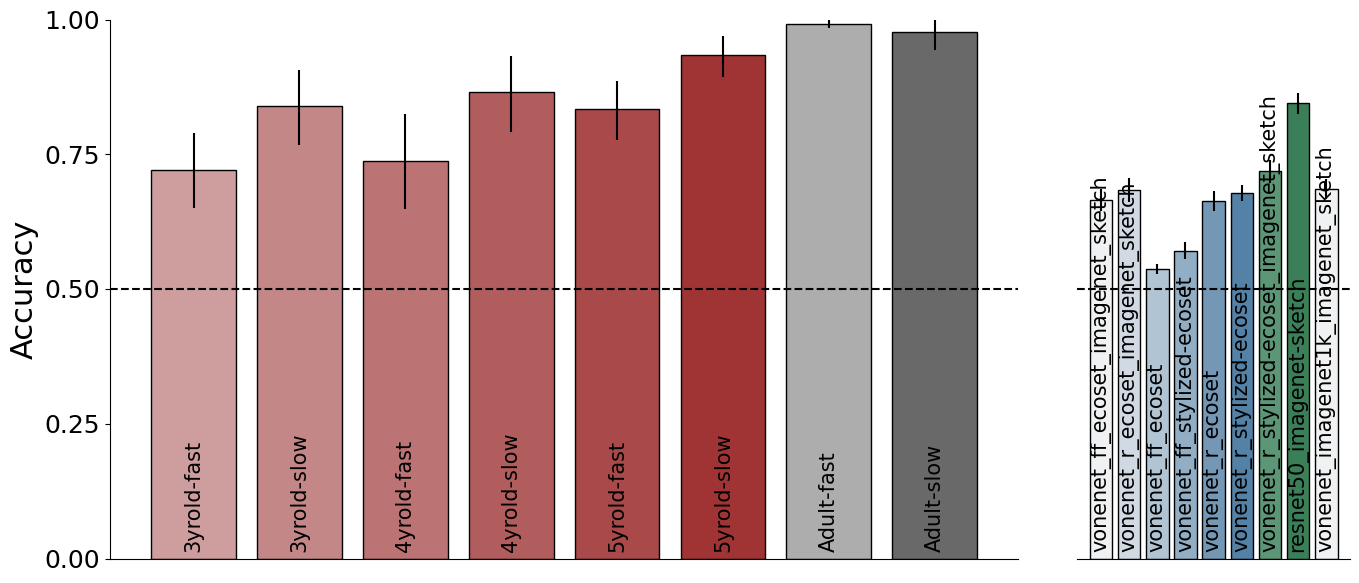

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


perturbed


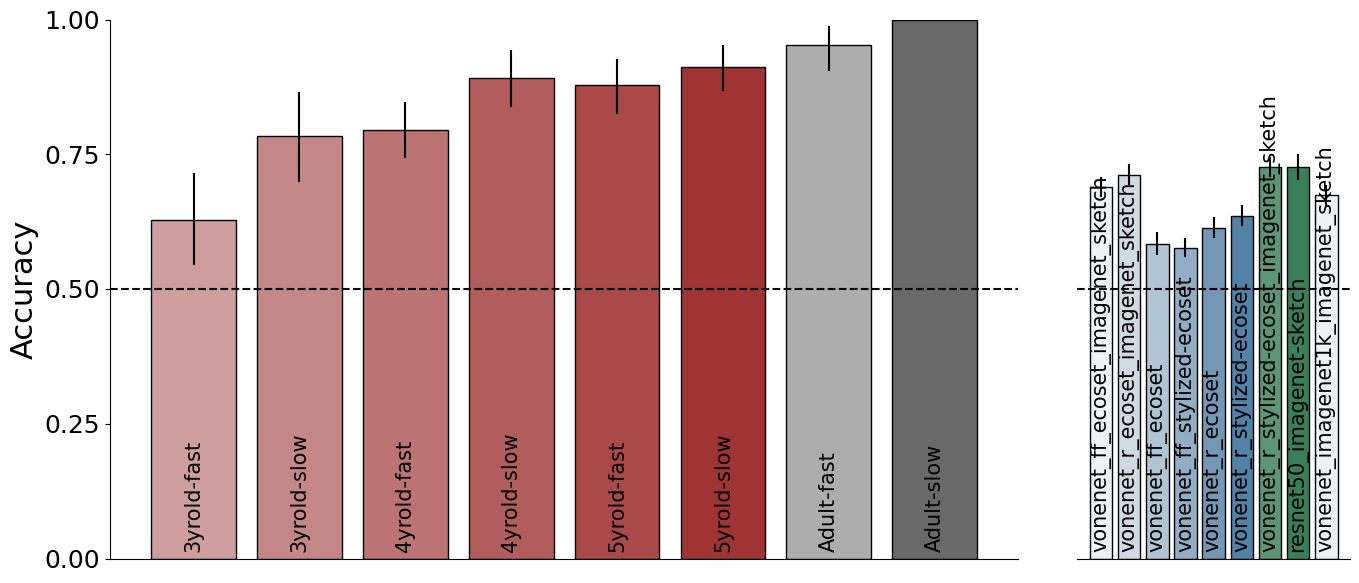

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


deleted


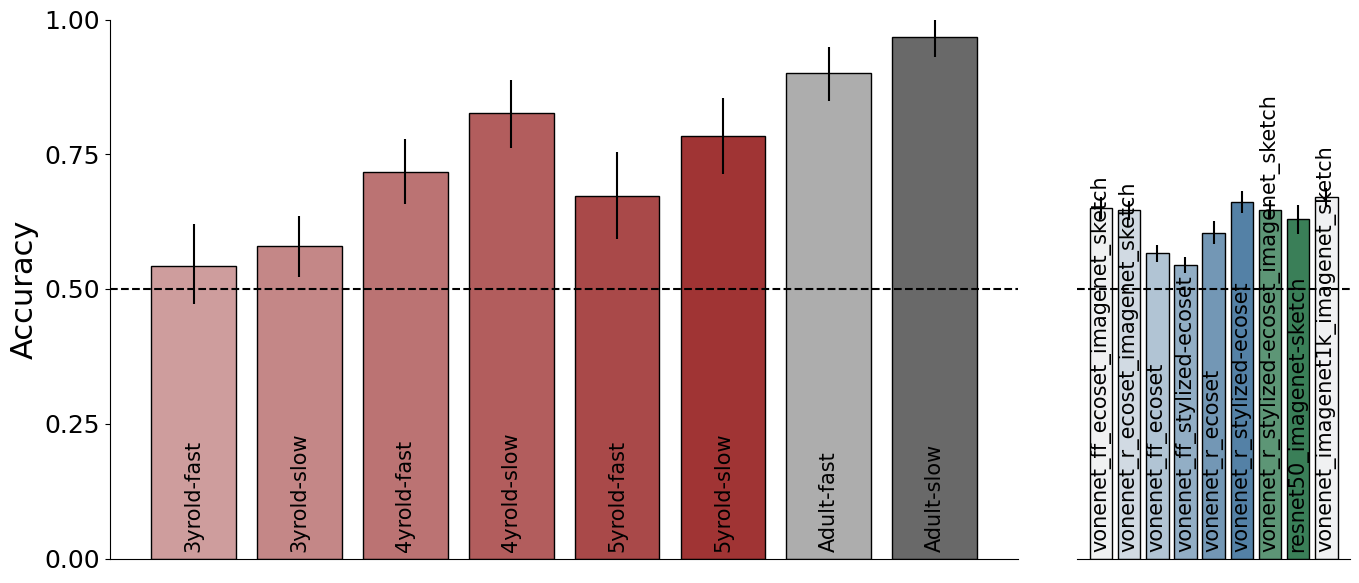

In [6]:
fig_sizes = [5.6, 1]


'''
model_colors = [sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:],
                sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + sns.light_palette("orange", 5)[-2:] + sns.light_palette("violet", 5)[-1:],
                sns.light_palette("gold", 3)[-2:] + sns.light_palette("purple", 5)[-3:5]]  
'''

for cond in cond_names:
    print(cond)

    all_organisms = pd.read_csv(f'{results_dir}/{cond}_model_comparison_finetuned.csv')

    fig, ax = plt.subplots(1,2, figsize=(16,7), width_ratios=[.5,.15],sharey=False)

    for panel in [0,1]:
        full_summary = all_organisms[all_organisms['fig_number'] == panel]
        



        #Make bar plot with each model as a different color, and CIs for error bars
        sns.barplot(data = full_summary, x = 'model', y = 'acc', hue = 'model', dodge=False, palette=model_colors[panel], edgecolor = 'k',ax=ax[panel])

        #add error bars

        ax[panel].errorbar(x = full_summary['model'], y = full_summary['acc'], yerr = [full_summary['acc'] - full_summary['ci_low'], full_summary['ci_high']-full_summary['acc']] , fmt = 'none', color = 'black', capsize = 0)

        #set y limits
        ax[panel].set_ylim([0,1])
        if panel == 0:
            ax[panel].set_ylabel('Accuracy', fontsize = 22)
            ax[panel].spines['left'].set_color('k')
            #increase font size of y axis labels
            #ax[panel].set_yticklabels(fontsize = 20)

            #set y-axis increments to .25
            ax[panel].set_yticks(np.arange(0, 1.25, .25))
            ax[panel].tick_params(axis='y', labelsize=18)
            

        else:
            pass
            #remove y label
            #ax[panel].set_ylabel('')
            
            #remove y ticks
            ax[panel].set_yticks([])
            #remove y tick labels
            ax[panel].set_yticklabels([])
            #remove y axis line
            ax[panel].spines['left'].set_visible(False)
            #remove y axis label
            #remove y axis label
            ax[panel].set_ylabel('')
            
            
        #remove tick labels
        
        ax[panel].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        
        
        
        #add dotted line at .5
        ax[panel].axhline(y=.5, color='black', linestyle='--')

        #remove x axis label
        #ax[panel].xlabel('')
            #remove x ticks and labels
        ax[panel].set_xticks([])
        ax[panel].set_xticklabels([])
        ax[panel].set_xlabel('')


        ax[panel].spines['bottom'].set_color('k')
    

        #remove top and right axes
        ax[panel].spines['top'].set_visible(False)
        ax[panel].spines['right'].set_visible(False)

        
        
        
        

        #remove top and right spines
        #sns.despine()

        #make left and bottom spines black
        #ax.spines['left'].set_color('black')

        #move labels inside bars
        for p, model_name in zip(ax[panel].patches, full_summary['model']):
            ax[panel].annotate(f'{model_name}', (p.get_x() + p.get_width() / 2., 0 ),
                        ha='center', va='bottom', fontsize=15, color='black', xytext=(0, 5), rotation = 90,
                        textcoords='offset points')
        
    

        #remove legend
        ax[panel].legend().remove()
        
    plt.subplots_adjust(wspace=.1, hspace=0)
    #save
    plt.savefig(f'{fig_dir}/{cond}_model_comparison_finetuned.png', dpi = 300, bbox_inches = 'tight')
    
    plt.pause(.001)



## Line plots comparing conditions

In [7]:
'''Line plot comparing models across conditions'''

#load all cond files and append them
for cond in model_conds:
    print(cond)

    curr_cond = pd.read_csv(f'{results_dir}/{cond}_model_comparison{suf}.csv')

    #if first cond, create full_summary
    if cond == model_conds[0]:
        full_summary = curr_cond
    else:
        full_summary = pd.concat([full_summary, curr_cond], axis = 0)

    #rename Outline to Complete, Pert to Perturbed, and IC to Deleted
    full_summary['condition'] = full_summary['condition'].replace({'Outline':'Complete'})
    full_summary['condition'] = full_summary['condition'].replace({'Pert':'Perturbed'})
    full_summary['condition'] = full_summary['condition'].replace({'IC':'Deleted'})

    #capitalize condition
    full_summary['condition'] = full_summary['condition'].str.capitalize()





Outline
Pert
IC


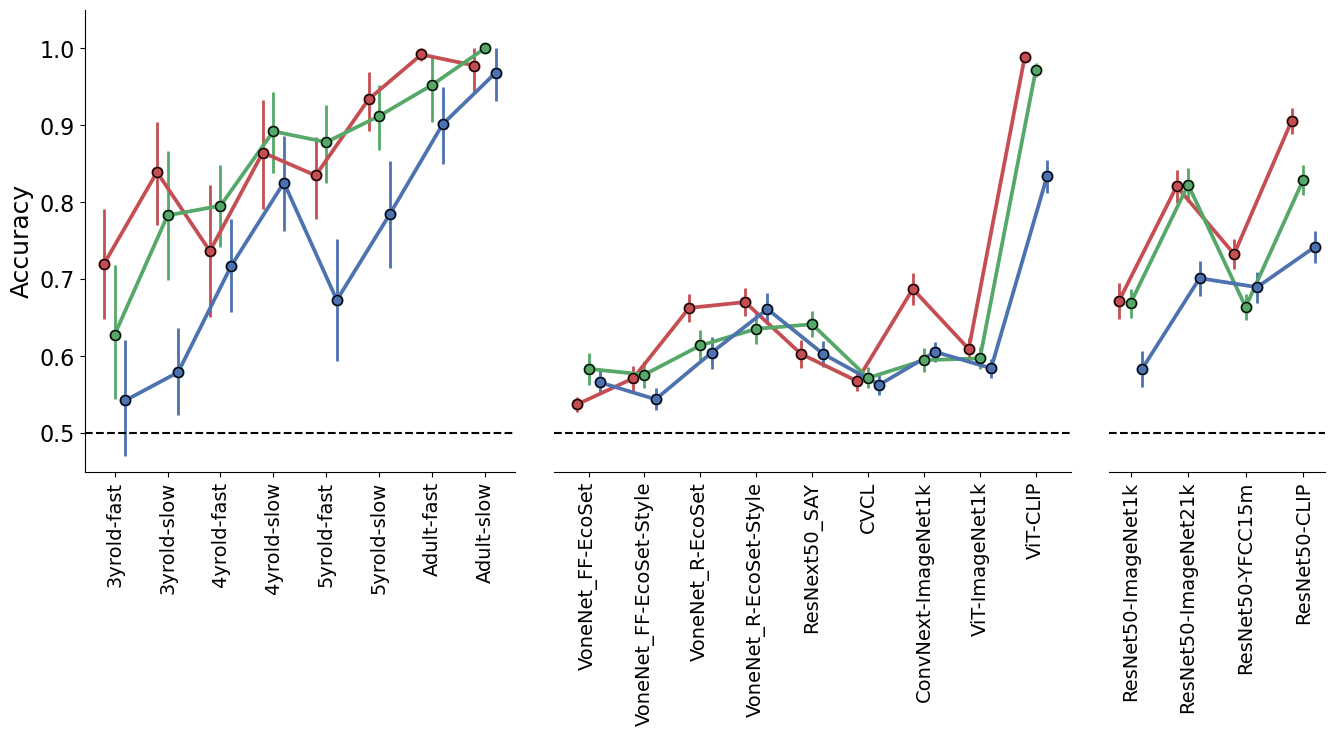

In [112]:
#creat line plot in seaborn with x = model, y = acc, hue = condition

colors = [all_colors_hex[3],all_colors_hex[2],all_colors_hex[0]]
fig_sizes = [5.6, 6.3, 2.8]
model_conds = ['Complete', 'Perturbed', 'Deleted']
offset = [-.2,0,.2]

fig, ax = plt.subplots(1,3, figsize=(16,6), width_ratios=[1,1.2,.5],sharey=False)

for panel in [0,1,2]:
    curr_panel = full_summary[full_summary['fig_number'] == panel]
    """ #create line plot
    sns.lineplot(data = curr_panel, x = 'model', y = 'acc', hue = 'condition', 
                 linewidth  = 3, palette = colors, ax=ax[panel],zorder = 0)

    #create dots on top of them 
    sns.scatterplot(data = curr_panel, x = 'model', y = 'acc', hue = 'condition', 
                    s = 40, edgecolor = 'k', palette = colors, ax=ax[panel],zorder = 2)
     """
    sns.pointplot(data = curr_panel, x = 'model', y = 'acc', hue = 'condition',
                  dodge = .4, palette = colors, ax=ax[panel])

    for cond in model_conds:
        curr_cond = curr_panel[curr_panel['condition'] == cond]
    
        ax[panel].errorbar(x = curr_cond['model'].reset_index().index + offset[model_conds.index(cond)], y = curr_cond['acc'], yerr = [curr_cond['acc'] - curr_cond['ci_low'], curr_cond['ci_high']-curr_cond['acc']] , 
            fmt = 'none', color = colors[model_conds.index(cond)], elinewidth = 2, capsize = 0, zorder = 0)
        ax[panel].scatter(curr_cond['model'].reset_index().index + offset[model_conds.index(cond)], curr_cond['acc'], color = colors[model_conds.index(cond)], s = 50, edgecolor = 'k', zorder = 3)

    #set y limits
    #ax[panel].set_ylim([.5,1.25])
    if panel == 0:
        ax[panel].set_ylabel('Accuracy', fontsize = 18)
        ax[panel].spines['left'].set_color('k')
        #increase font size of y axis labels
        #ax[panel].set_yticklabels(fontsize = 20)

        #set y-axis increments to .25
        ax[panel].set_yticks(np.arange(.5, 1.1, .1))
        ax[panel].tick_params(axis='y', labelsize=16)
        

    else:
        pass
        #remove y label
        #ax[panel].set_ylabel('')
        
        #remove y ticks
        ax[panel].set_yticks([])
        #remove y tick labels
        ax[panel].set_yticklabels([])
        #remove y axis line
        ax[panel].spines['left'].set_visible(False)
        #remove y axis label
        #remove y axis label
        ax[panel].set_ylabel('')
        
        
    #remove tick labels
    
    ax[panel].tick_params(axis='x',labelsize=14, rotation = 90)
    
    #remove legend
    ax[panel].legend().remove()
    
    
    #add dotted line at .5
    ax[panel].axhline(y=.5, color='black', linestyle='--')

    #remove x axis label
    #ax[panel].xlabel('')
        #remove x ticks and labels


    ax[panel].spines['bottom'].set_color('k')


    #remove top and right axes
    ax[panel].spines['top'].set_visible(False)
    ax[panel].spines['right'].set_visible(False)
    ax[panel].set_xlabel('')
    ax[panel].set_ylim([.45,1.05])
    plt.subplots_adjust(wspace=.1, hspace=0)

    #angle labels diagonally
    #ax[panel].xticks(rotation=90)
plt.show()

    
    





## Determine best classifier train imgs

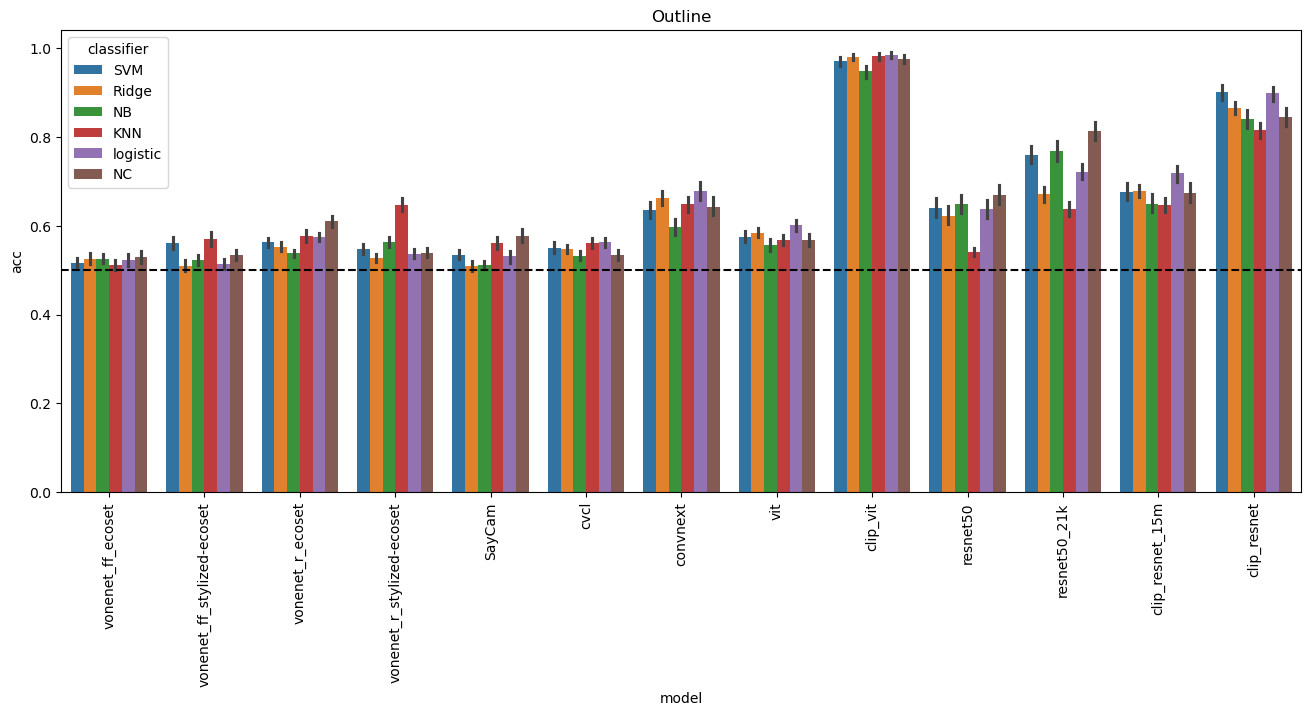

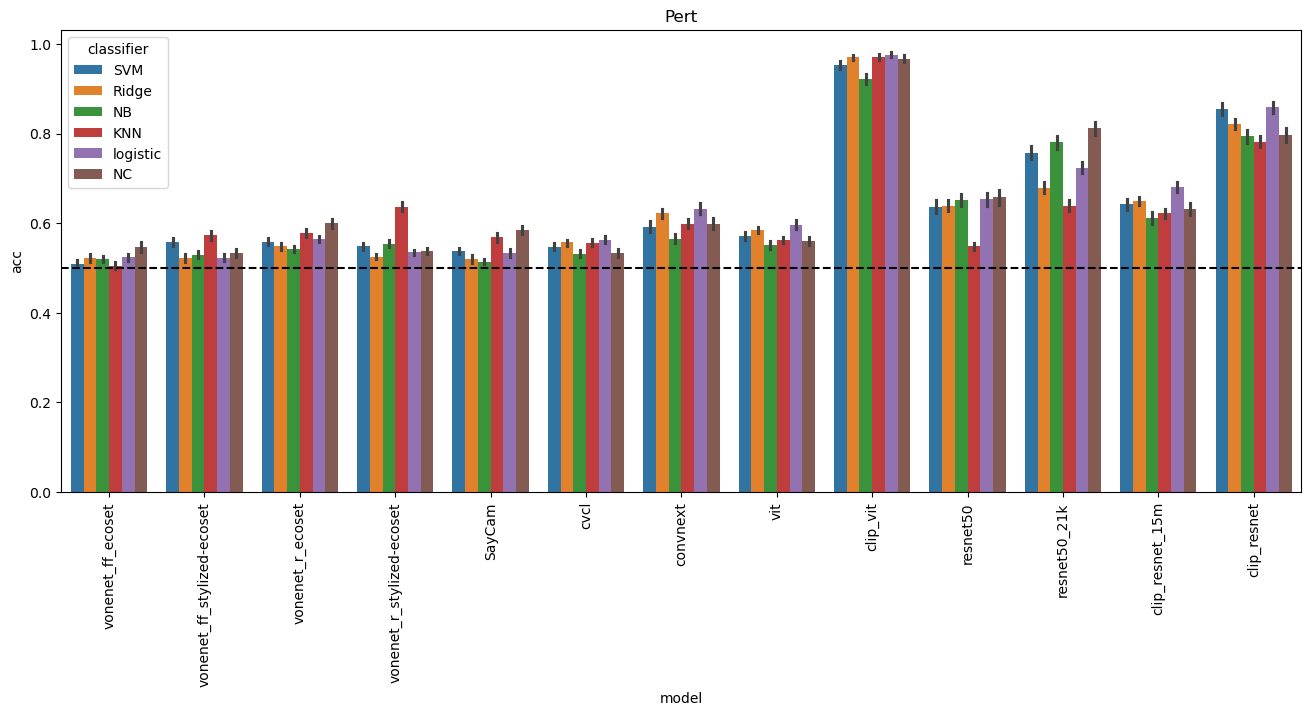

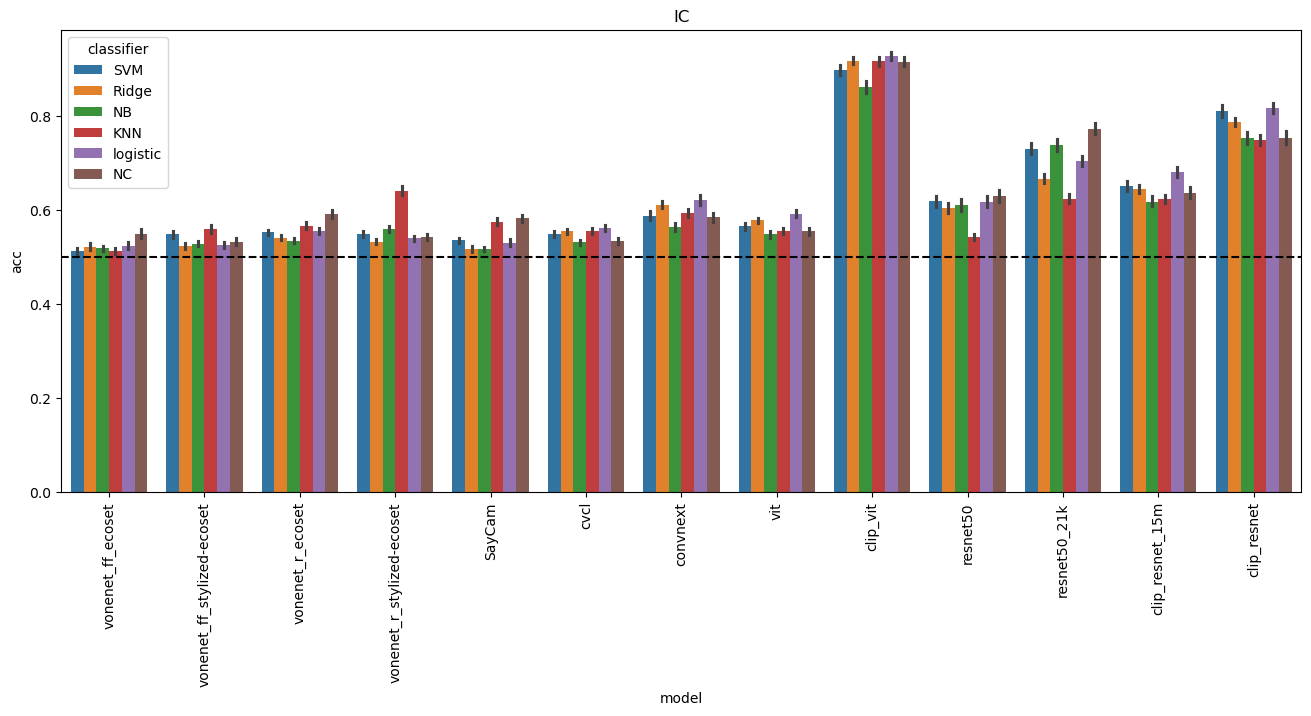

In [23]:
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 
              'SayCam', 'cvcl',
                'convnext', 'vit', 'clip_vit',
                'resnet50', 'resnet50_21k','clip_resnet_15m', 'clip_resnet']

classifiers = ['SVM', 'Ridge', 'NB', 'KNN', 'logistic', 'NC']

model_conds = ['Outline','Pert','IC']
#model_conds = ['Outline']

model_df = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc','sem'])
for cond in model_conds:
    for model in model_arch:
            
            for classifier in classifiers:
            

                for train_n in [150]:
                    
                        model_file = f'{results_dir}/models/{model}_{classifier}_train{train_n}_test{cond}.csv'
                        if os.path.exists(model_file):
                            temp_df = pd.read_csv(model_file)

                            #groupby 
                            #temp_df_mean = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].mean().reset_index()
                            #sem = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].sem().reset_index()
                            
                            
                            model_df = pd.concat([model_df, temp_df], axis = 0)
                        else:
                            print(f'no {model}_{classifier}_train{train_n}_test{cond}.csv')

    fig, ax = plt.subplots(1,1, figsize=(16,6))
    sns.barplot(data = model_df, x = 'model', y = 'acc', hue = 'classifier', dodge=True)

    #add line at .5
    ax.axhline(y=.5, color='black', linestyle='--')
    #add title
    plt.title(cond)
    #angle x labels
    plt.xticks(rotation=90)
    plt.show()
    plt.pause(.001)



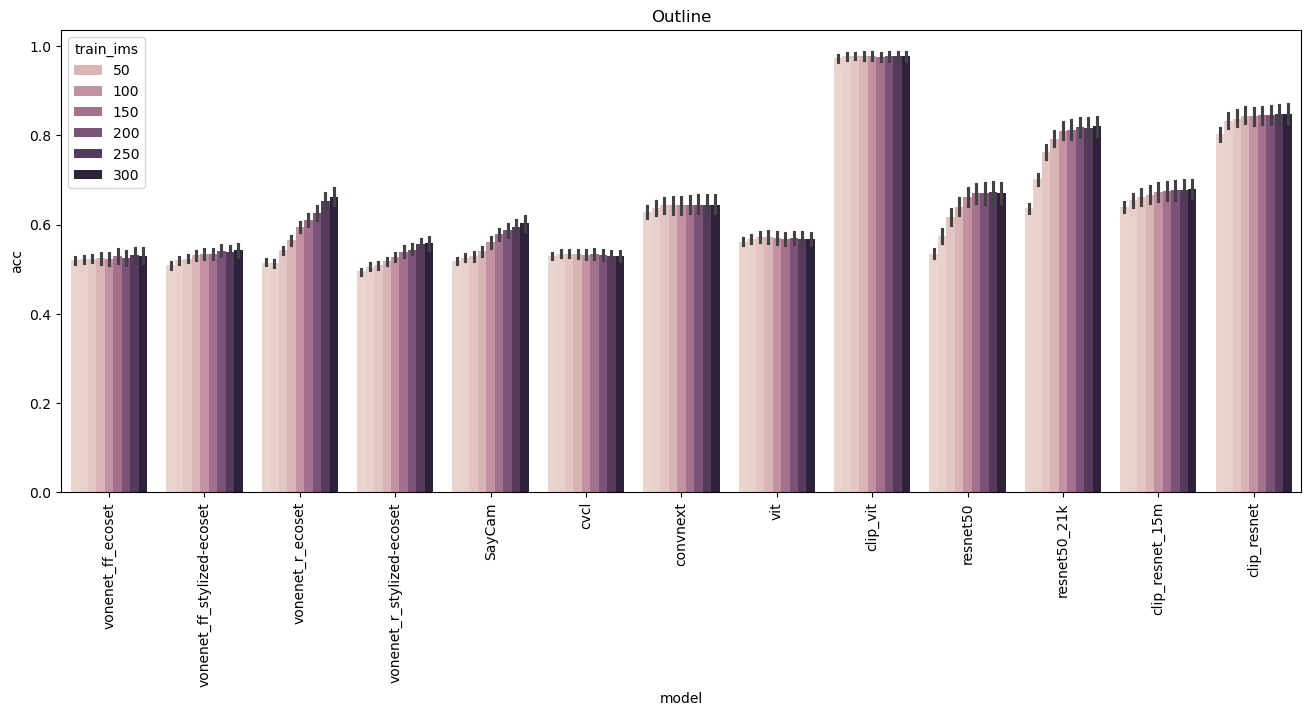

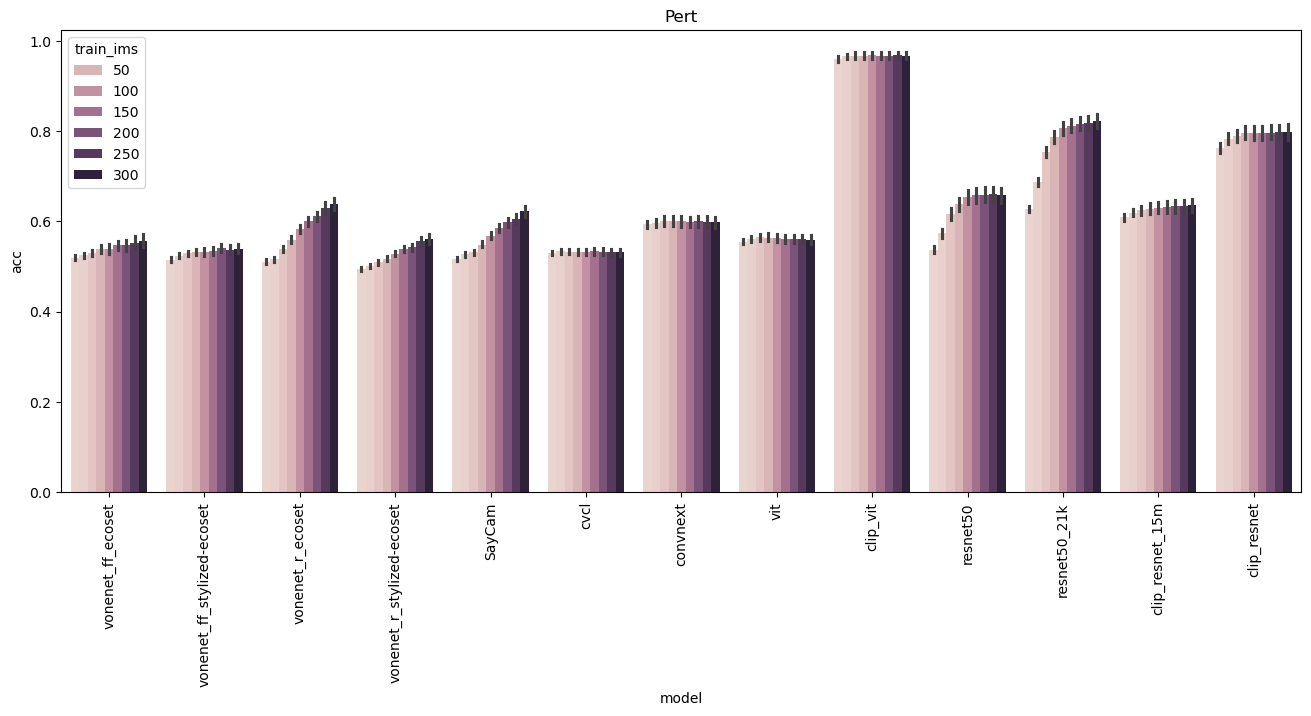

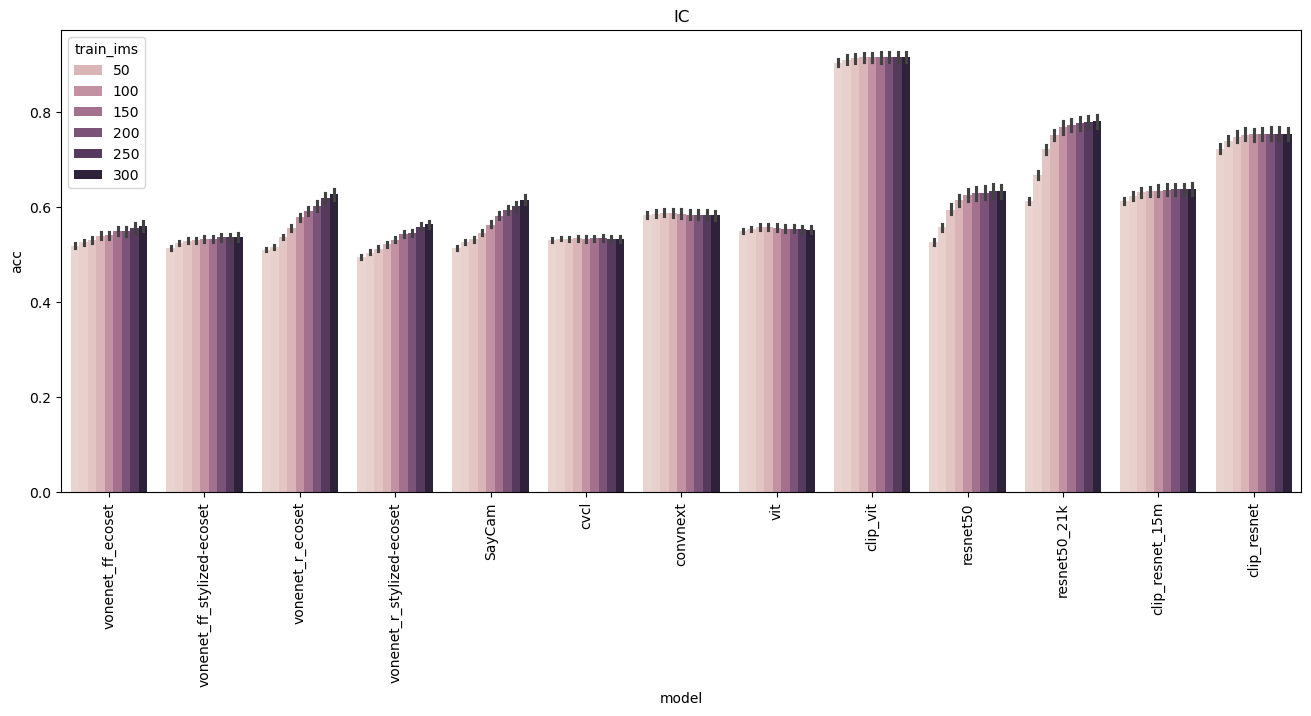

In [8]:
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 
              'SayCam', 'cvcl',
                'convnext', 'vit', 'clip_vit',
                'resnet50', 'resnet50_21k','clip_resnet_15m', 'clip_resnet']

classifiers = ['SVM', 'Ridge', 'NB', 'KNN', 'logistic', 'NC']

classifiers = ['NC']

train_ns = [5, 10, 25, 50, 100, 150, 200, 250, 300]

model_conds = ['Outline','Pert','IC']


model_df = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc','sem'])
for cond in model_conds:
    for model in model_arch:
            
            for classifier in classifiers:
            

                for train_n in train_ns:
                    
                        model_file = f'{results_dir}/models/{model}_{classifier}_train{train_n}_test{cond}.csv'
                        if os.path.exists(model_file):
                            temp_df = pd.read_csv(model_file)

                            #groupby 
                            #temp_df_mean = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].mean().reset_index()
                            #sem = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].sem().reset_index()
                            
                            
                            model_df = pd.concat([model_df, temp_df], axis = 0)
                        else:
                            print(f'no {model}_{classifier}_train{train_n}_test{cond}.csv')


    fig, ax = plt.subplots(1,1, figsize=(16,6))
    sns.barplot(data = model_df, x = 'model', y = 'acc', hue = 'train_ims', dodge=True)
    #add title
    plt.title(cond)
    #angle x labels
    plt.xticks(rotation=90)
    plt.show()
    plt.pause(.001)
